<a href="https://colab.research.google.com/github/ASEM000/pytreeclass/blob/main/pytreeclass_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytreeclass

In [ ]:
from pytreeclass import treeclass,tree_viz,static_field 
import jax
from jax import numpy as jnp 
import matplotlib.pyplot as plt 

## Build and visualize PyTorch-like NN class in JAX

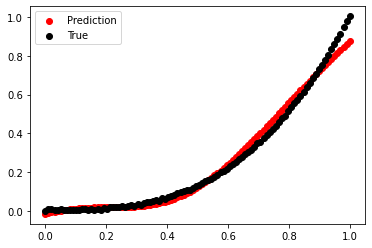

In [ ]:
import jax
from jax import numpy as jnp
from pytreeclass import treeclass,static_field,tree_viz

@treeclass
class Linear :

 weight : jnp.ndarray
 bias   : jnp.ndarray

 def __init__(self,key,in_dim,out_dim):
   self.weight = jax.random.normal(key,shape=(in_dim, out_dim)) * jnp.sqrt(2/in_dim)
   self.bias = jnp.ones((1,out_dim))

 def __call__(self,x):
   return x @ self.weight + self.bias

@treeclass
class StackedLinear:
   l1 : Linear
   l2 : Linear
   l3 : Linear

   def __init__(self,key,in_dim,out_dim):

       keys= jax.random.split(key,3)

       self.l1 = Linear(key=keys[0],in_dim=in_dim,out_dim=128)
       self.l2 = Linear(key=keys[1],in_dim=128,out_dim=128)
       self.l3 = Linear(key=keys[2],in_dim=128,out_dim=out_dim)

   def __call__(self,x):
       x = self.l1(x)
       x = jax.nn.tanh(x)
       x = self.l2(x)
       x = jax.nn.tanh(x)
       x = self.l3(x)

       return x


x = jnp.linspace(0,1,100)[:,None]
y = x**3 + jax.random.uniform(jax.random.PRNGKey(0),(100,1))*0.01

model = StackedLinear(in_dim=1,out_dim=1,key=jax.random.PRNGKey(0))

def loss_func(model,x,y):
   return jnp.mean((model(x)-y)**2 )

@jax.jit
def update(model,x,y):
   value,grads = jax.value_and_grad(loss_func)(model,x,y)
   # no need to use `jax.tree_map` to update the model
   #  as it model is wrapped by @treeclass
   return value , model-1e-3*grads

for _ in range(1,2001):
   value,model = update(model,x,y)

plt.scatter(x,model(x),color='r',label = 'Prediction')
plt.scatter(x,y,color='k',label='True')
plt.legend()

In [ ]:
print(tree_viz.summary(model))

┌──────┬───────┬─────────┬───────────────────┐
│Type  │Param #│Size     │Config             │
├──────┼───────┼─────────┼───────────────────┤
│Linear│256    │1.000 KB │bias=f32[1,128]    │
│      │       │         │weight=f32[1,128]  │
├──────┼───────┼─────────┼───────────────────┤
│Linear│16,512 │64.500 KB│bias=f32[1,128]    │
│      │       │         │weight=f32[128,128]│
├──────┼───────┼─────────┼───────────────────┤
│Linear│129    │516.000 B│bias=f32[1,1]      │
│      │       │         │weight=f32[128,1]  │
└──────┴───────┴─────────┴───────────────────┘
Total params :	16,897
Inexact params:	16,897
Other params:	0
----------------------------------------------
Total size :	66.004 KB
Inexact size:	66.004 KB
Other size:	0.000 B


In [ ]:
print(tree_viz.tree_box(model,array=x))

┌──────────────────────────────────────┐
│StackedLinear(Parent)                 │
├──────────────────────────────────────┤
│┌────────────┬────────┬──────────────┐│
││            │ Input  │ f32[100,1]   ││
││ Linear(l1) │────────┼──────────────┤│
││            │ Output │ f32[100,128] ││
│└────────────┴────────┴──────────────┘│
│┌────────────┬────────┬──────────────┐│
││            │ Input  │ f32[100,128] ││
││ Linear(l2) │────────┼──────────────┤│
││            │ Output │ f32[100,128] ││
│└────────────┴────────┴──────────────┘│
│┌────────────┬────────┬──────────────┐│
││            │ Input  │ f32[100,128] ││
││ Linear(l3) │────────┼──────────────┤│
││            │ Output │ f32[100,1]   ││
│└────────────┴────────┴──────────────┘│
└──────────────────────────────────────┘


In [ ]:
print(tree_viz.tree_diagram(model))

StackedLinear
    ├── l1=Linear
    │   ├── weight=f32[1,128]
    │   └── bias=f32[1,128] 
    ├── l2=Linear
    │   ├── weight=f32[128,128]
    │   └── bias=f32[1,128] 
    └──l3=Linear
        ├── weight=f32[128,1]
        └── bias=f32[1,1]       


## Operations on PyTrees

In [ ]:
# get layer1
layer1 = model.l1
# layer1 repr
print(f"{layer1!r}")

Linear(weight=f32[1,128],bias=f32[1,128])


In [ ]:
# layer1 str
print(f"{layer1!s}")

Linear(
  weight=
    [[-0.5154296  -0.5802525   1.1998714  -3.140695   -0.9105417   0.02529282
      -1.5031999   0.32465786 -0.6680716   2.0307639  -1.1041818   0.34423974
       0.12412212 -1.0993127   2.6928818  -0.2937158   1.1684799  -0.32412982
       0.22355585  0.82687426  1.7829171  -0.4171079  -0.63438946  2.479182
       0.93652976  2.3307116  -1.1300071  -0.17676698  0.4798958  -0.7416262
       1.8679861  -0.0521381   0.68760747  0.22854356 -0.29521447 -0.55318934
       0.02394825 -2.104279   -0.7276673   1.1119531  -0.53309    -0.082045
       0.01626187  0.78844047 -2.4057457   2.3664682  -0.14585978 -2.1782465
       1.8009057  -1.3652617  -1.4579713   0.25327715  0.9234403  -0.48173955
      -1.5291252   0.52952564  1.1894413   0.36196357  1.4896038  -0.40946943
       0.20324053 -0.10555436  1.1844754   0.13451566 -1.0598036  -0.18996547
       3.0499792  -0.7093165  -2.8729014   1.3705946   1.6692107   1.3717211
       0.83655554 -1.3739197   1.0907171   0.61527205

In [ ]:
# get only positive values
print(layer1.at[layer1>0].get())

Linear(
  weight=
    [1.1998714  0.02529282 0.32465786 2.0307639  0.34423974 0.12412212
     2.6928818  1.1684799  0.22355585 0.82687426 1.7829171  2.479182
     0.93652976 2.3307116  0.4798958  1.8679861  0.68760747 0.22854356
     0.02394825 1.1119531  0.01626187 0.78844047 2.3664682  1.8009057
     0.25327715 0.9234403  0.52952564 1.1894413  0.36196357 1.4896038
     0.20324053 1.1844754  0.13451566 3.0499792  1.3705946  1.6692107
     1.3717211  0.83655554 1.0907171  0.61527205 0.9569915  1.695117
     2.094522   3.0138707  0.22433756 0.19061178 1.613289   2.0533955
     0.27430922 0.01665495 0.69018817 0.77048993 0.6437899  0.6674185
     0.80126095 1.2289534  1.4951304  0.24195789 0.63211864 1.0575486
     0.28276387 0.5023281  0.84281    2.2935853  0.53782773 1.847664
     2.5121255 ],
  bias=
    [1.0002741  1.0006088  0.9998904  0.9964123  1.0022342  0.9997558
     1.0003592  0.99893236 0.9994249  1.0000763  0.99869734 1.0005594
     1.0000646  0.99983144 0.9999976  0.9984422

In [ ]:
# set negative values to 0
print(layer1.at[layer1<0].set(0))


Linear(
  weight=
    [[0.         0.         1.1998714  0.         0.         0.02529282
      0.         0.32465786 0.         2.0307639  0.         0.34423974
      0.12412212 0.         2.6928818  0.         1.1684799  0.
      0.22355585 0.82687426 1.7829171  0.         0.         2.479182
      0.93652976 2.3307116  0.         0.         0.4798958  0.
      1.8679861  0.         0.68760747 0.22854356 0.         0.
      0.02394825 0.         0.         1.1119531  0.         0.
      0.01626187 0.78844047 0.         2.3664682  0.         0.
      1.8009057  0.         0.         0.25327715 0.9234403  0.
      0.         0.52952564 1.1894413  0.36196357 1.4896038  0.
      0.20324053 0.         1.1844754  0.13451566 0.         0.
      3.0499792  0.         0.         1.3705946  1.6692107  1.3717211
      0.83655554 0.         1.0907171  0.61527205 0.         0.9569915
      0.         1.695117   0.         0.         2.094522   3.0138707
      0.22433756 0.19061178 1.613289   2.05